# Homework 2 - 95-791 Data Mining (Fall 2021) 
## Name: Yifan Zhou 
#### Due: Friday, November 12th, before 1PM (EST)


### Changing the author field and file name.

 (a) Change the `name:` field on the Jupyter document from Your Name Here to your own name.

 (b) Rename this file to "Homework2_F21_YourHameHere.ipynb", where YourNameHere is changed to your own name.


### Installing and loading packages

Before you begin this Homework make sure you have installed all the required libraries. Load the libraries as indicated below.

You only need to install libraries once.  Once they're installed, you may use them by **importing** the libraries using the `import` command.  For today's lab, you'll want to run the following code


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
import time
# set warnings off
import warnings
warnings.filterwarnings('ignore')
from statistics import mean

%matplotlib inline
plt.style.use('seaborn-white')

For this problem we’ll be working with two years of the bicycle sharing systems for New York City (Citibike). The dataset contains daily bike trip counts, along with daily measurements on environmental and seasonal information that may affect the bikesharing.

Here’s information on what the variables mean.

- trips - daily total number of bike trips taken (all stations) - target variable.
- precipitation - daily inches of rain
- snow_depth - daily inches of snow. Accoding to NOAA "Determine the depth of the new and old snow remaining on the ground at observation time".
- snowfall - according to NOAA "Measure and record the snowfall (snow, ice pellets ) since the previous snowfall observation (24 hours)."
- max_temperature - daily maximum temperature in Farenheit (highest temperature reached)
- min_temperature - daily minimum temperature in Farenheit (lowest temperature reached)
- average_wind_speed - measured hourly in mph and averaged for daily value
- year 
- holiday
    - True
    - False
- stations in service - docking stations working per day
- weekday
    - True
    - False
- weekday_non_holiday
    - True
    - False

More details on snow measurements [here](https://www.weather.gov/gsp/snow)

---

### Question 1. Data Processing [3 pts]
Let's start by loading and pre-processing our dataset.

**1)a) Load the `bikes` dataset into a dataframe called `bikes`. Check that there are no missing values in your dataset. If they are, take care of them appropriately. Print the first five rows.** [0 pts]

In [28]:
bikes = pd.read_csv("daily_citi_bike_trip_counts_and_weather.csv")
print(bikes.isnull().sum(axis = 0)) 
print("Number of Missing Values: %1.0f"%bikes.isnull().sum().sum()) # check if there is null
bikes = bikes.dropna(axis=1) # drop nas
print("Number of Missing Values: %1.0f"%bikes.isnull().sum().sum()) # check again. no nas 
bikes.head(5)

trips                  0
precipitation          0
snow_depth             0
snowfall               0
max_temperature        0
min_temperature        0
average_wind_speed     3
year                   0
season                 0
month                  0
holiday                0
stations_in_service    0
weekday                0
weekday_non_holiday    0
dtype: int64
Number of Missing Values: 3
Number of Missing Values: 0


,trips,precipitation,snow_depth,snowfall,max_temperature,min_temperature,year,season,month,holiday,stations_in_service,weekday,weekday_non_holiday
0,20138,0.649606,0.0,0.0,75.92,66.02,2013,summer,8,False,329,True,True
1,35792,0.000000,0.0,0.0,82.94,66.92,2013,summer,8,False,329,True,True
2,29540,0.059055,0.0,0.0,78.08,68.00,2013,summer,8,False,329,False,False
3,35253,0.000000,0.0,0.0,80.06,66.02,2013,summer,8,False,329,False,False
4,36776,0.000000,0.0,0.0,78.08,62.06,2013,summer,8,False,329,True,True


**1)b) We need to encode our qualitative predictors before we proceed into any modeling. Predictors `holiday`, `weekday`,`weekday_non_holiday` are type boolean, therefore you must cast them to be numerical. For predictor `season` you will either have to create [dummy variables](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) and append them to your dataframe or map each season to a different number (spring:1,summer:2,fall:3,winter:4). Print the first five rows of your dataset.** [2 pts]

In [29]:
def dummy_transform(x): # transform 0-1 variable
    if x == True:
        return 1
    else:
        return 0
    
bikes_clean = bikes.copy()
for col in ['holiday', 'weekday','weekday_non_holiday']:
    bikes[col] = bikes[col].apply(dummy_transform) # apply that function
bikes_clean = pd.concat([bikes, pd.get_dummies(bikes['season'], drop_first=True)], axis = 1) # transform category variable; drop 1 option to avoid multicollinearity
bikes_clean.drop(['season'], axis = 1, inplace = True)
bikes_clean.head(5)

,trips,precipitation,snow_depth,snowfall,max_temperature,min_temperature,year,month,holiday,stations_in_service,weekday,weekday_non_holiday,spring,summer,winter
0,20138,0.649606,0.0,0.0,75.92,66.02,2013,8,0,329,1,1,0,1,0
1,35792,0.000000,0.0,0.0,82.94,66.92,2013,8,0,329,1,1,0,1,0
2,29540,0.059055,0.0,0.0,78.08,68.00,2013,8,0,329,0,0,0,1,0
3,35253,0.000000,0.0,0.0,80.06,66.02,2013,8,0,329,0,0,0,1,0
4,36776,0.000000,0.0,0.0,78.08,62.06,2013,8,0,329,1,1,0,1,0


**1)d) Split your dataframe into `X` and `y` dataframe, and then split into `X_train`, `X_test`, `y_train` and `y_test`. Use a 80-20 ratio for the split and a random_state=(your birthday month). Print out your y_test.** [1pts]

In [30]:
# split the x and y
X = bikes_clean[bikes_clean.columns.difference(['trips'])]
y = bikes_clean['trips']
print('The shape of X is{}. The shape of y is{}'.format(X.shape, y.shape))
# split training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)
print('The shape of X_train is{}. The shape of X_test is{}. The shape of y_train is{}. The shape of y_test is{}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print(y_test)

The shape of X is(852, 14). The shape of y is(852,)
The shape of X_train is(681, 14). The shape of X_test is(171, 14). The shape of y_train is(681,). The shape of y_test is(171,)
441    26754
298    26930
136     7462
216    13801
482     3675
       ...  
188     2746
606    18075
435    30887
172    13407
396    23575
Name: trips, Length: 171, dtype: int64


---

### Question 2 - Linear vs Polynomial Models [10  pts]


**2)a) Use Scikit-learn to train a Linear Regression on your dataset. Print out the train MSE and train $R^2$, the test MSE and test $R^2$. How good of a fit is your Linear Model?**[5 pts]

In [31]:


# fit linear model with training
lm = LinearRegression(normalize = True)
lm.fit(X_train, y_train)
y_true = y_train
y_pred = lm.predict(X_train)
print('Train MSE: ', mean_squared_error(y_true, y_pred))
print("Training R-squared: ", lm.score(X_train,y_train))
y_true = y_test
y_pred = lm.predict(X_test)
print('Test MSE: ', mean_squared_error(y_true, y_pred))
print("Testing R-squared: ", lm.score(X_test,y_test))
linear_MSE = -mean(cross_val_score(LinearRegression(), X, y, scoring='neg_mean_squared_error', cv=10))

Train MSE:  16350117.14119731
Training R-squared:  0.8889416660005361
Test MSE:  17439809.20421631
Testing R-squared:  0.865897096489605


--> The R squared is pretty close to 1. The model is pretty good.

**2)b) Use Scikit-learn to train a Polynomial Regression on your dataset. Iterate through degrees 1 to 6, and for each degree print out the degree, its train MSE and its test MSE. Are any of the MSEs better than a Linear Regression? What can you comment on the results between the Train and Test MSEs?**[5 pts]

In [32]:
# polynomial fit
def train_poly(i):
    poly_model = PolynomialFeatures(degree=i)
    X_poly_train = poly_model.fit_transform(X_train)
    X_poly_test = poly_model.fit_transform(X_test)
    
    lm_poly = LinearRegression(normalize = True)
    lm_poly.fit(X_poly_train, y_train)
    y_pred_poly = lm_poly.predict(X_poly_train)

    print('Degree:', i)
    print('Train MSE: ', mean_squared_error(y_train, y_pred_poly))
    y_pred_poly = lm_poly.predict(X_poly_test)
    print('Test MSE: ', mean_squared_error(y_test, y_pred_poly))


for degree in range(1,7):
    train_poly(degree)



Degree: 1
Train MSE:  16350117.141197331
Test MSE:  17439809.20421648
Degree: 2
Train MSE:  6970759.620572002
Test MSE:  2.001290570639936e+26
Degree: 3
Train MSE:  3070882.303964758
Test MSE:  4.822581241872023e+22
Degree: 4
Train MSE:  226931.18130484238
Test MSE:  6.344946739999516e+24
Degree: 5
Train MSE:  2149.42805300387
Test MSE:  9.837313957621644e+19
Degree: 6
Train MSE:  2149.428047577821
Test MSE:  1.2649215121860893e+19


--> None of the polynomial model's test MSE is smaller than the original model. When the degree gets larger, the training MSE is deceasing. The flexibility increases in a way that the model is so influenced by the training data that it performs poorly in predicting future data.

---

### Question 3 - Variable Selection [15 pts]

Sequential Feature Selection (SFS) in the equivalent of Forward or Backwards stepwise selection in scikitlearn. SFS will choose the best new feature in each iteration and add it to the model. To measure and select the best feature to add to the combination in each SFS uses the cross-validation score. You can find the full description of SFS [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html?highlight=sequential%20feature#sklearn.feature_selection.SequentialFeatureSelector).

In [33]:
from sklearn.feature_selection import SequentialFeatureSelector

Let's try SFS as a Forward stepwise selection. Look a the description below for SFS and apply sfs to the boston dataset. For this question, use a linear model, pick the number of features to select, do forward sfs, use the MSE, and a cv with k=10.

**SequentialFeatureSelector**

- estimator - this will be a certain model. For example LinearRegression()
- n_features_to_select - Default is `None`, which means half of the features are selected.
- directions - `backward` or `forward`" selection.
- scoring - take a loook at the [metrics and scoring](https://scikit-learn.org/0.24/modules/model_evaluation.html#scoring-parameter) reference. A common metric for regression would be `neg_mean_squared_error` (negative MSE)
- cv - cross-validation. Default=`None` will yield a 5-fold cross validation. Otherwise change this number.

*Note: You do not need to split up your dataset, you are choosing the best features and SFS comes with CV*

**3)a)Complete and run the code below. Select four features with the SFS build a LinearRegression. Use a `k=10` for your cross validation. What is the $R^2$ of this model?**[4pts]

In [34]:
model= LinearRegression(normalize = True)
sfs = SequentialFeatureSelector(model, 
                                n_features_to_select = 4, 
                                direction="forward",
                                scoring='neg_mean_squared_error',
                                cv= 10) 
sfs = sfs.fit(X,y)
feature_names= X.columns
print("Features selected by forward sequential selection: "+str(feature_names[sfs.get_support()]))

Features selected by forward sequential selection: Index(['max_temperature', 'precipitation', 'stations_in_service',
       'weekday_non_holiday'],
      dtype='object')


In [35]:
lm = LinearRegression(normalize = True)
lm.fit(X[feature_names[sfs.get_support()]], y) # use the selected feature to fit
y_true = y
y_pred = lm.predict(X[feature_names[sfs.get_support()]])
print('R-squared: ', lm.score(X[feature_names[sfs.get_support()]],y))

R-squared:  0.8537056645756058


**3)b) Use 3)a) and put it inside a loop, from 1 to your total number of features). Print the results (Number of features and features selected). What are the features selected when the model has 6 features?** [3pts]

In [36]:
for degree in range(1, len(X.columns)):
    model= LinearRegression(normalize = True)
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = degree, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv= 10) 
    sfs = sfs.fit(X,y)
    feature_names= X.columns
    print('Degree = ', degree)
    print("Features selected by forward sequential selection: "+str(feature_names[sfs.get_support()]))

Degree =  1
Features selected by forward sequential selection: Index(['max_temperature'], dtype='object')
Degree =  2
Features selected by forward sequential selection: Index(['max_temperature', 'stations_in_service'], dtype='object')
Degree =  3
Features selected by forward sequential selection: Index(['max_temperature', 'stations_in_service', 'weekday_non_holiday'], dtype='object')
Degree =  4
Features selected by forward sequential selection: Index(['max_temperature', 'precipitation', 'stations_in_service',
       'weekday_non_holiday'],
      dtype='object')
Degree =  5
Features selected by forward sequential selection: Index(['max_temperature', 'month', 'precipitation', 'stations_in_service',
       'weekday_non_holiday'],
      dtype='object')
Degree =  6
Features selected by forward sequential selection: Index(['max_temperature', 'month', 'precipitation', 'stations_in_service',
       'weekday_non_holiday', 'winter'],
      dtype='object')
Degree =  7
Features selected by forwar

--> When degree = 6, the features selected are 'max_temperature', 'month', 'precipitation', 'stations_in_service',
       'weekday_non_holiday', 'winter'. 

**3)c) Use your loop from 3)b) and add a [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to the loop. For each iteration print the predictors selected and the average CV. Save all the CV errors in an array.** [4pts]

In [37]:
cv_errors = []
for degree in range(1, len(X.columns)):
    model= LinearRegression(normalize = True)
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = degree, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv= 10) 
    sfs = sfs.fit(X,y)
    feature_names= X.columns
    print('Degree = ', degree)
    print("Features selected by forward sequential selection: "+str(feature_names[sfs.get_support()]))
    sum = 0
    for score in cross_val_score(LinearRegression(), X[feature_names[sfs.get_support()]], y, scoring='neg_mean_squared_error', cv=10):
        sum += score
    print(sum/10)
    cv_errors.append(sum/10)
cv_errors = np.array(cv_errors)

Degree =  1
Features selected by forward sequential selection: Index(['max_temperature'], dtype='object')
-56506620.87336826
Degree =  2
Features selected by forward sequential selection: Index(['max_temperature', 'stations_in_service'], dtype='object')
-42494740.33248205
Degree =  3
Features selected by forward sequential selection: Index(['max_temperature', 'stations_in_service', 'weekday_non_holiday'], dtype='object')
-34318834.21694021
Degree =  4
Features selected by forward sequential selection: Index(['max_temperature', 'precipitation', 'stations_in_service',
       'weekday_non_holiday'],
      dtype='object')
-27572693.64113604
Degree =  5
Features selected by forward sequential selection: Index(['max_temperature', 'month', 'precipitation', 'stations_in_service',
       'weekday_non_holiday'],
      dtype='object')
-24617859.96013022
Degree =  6
Features selected by forward sequential selection: Index(['max_temperature', 'month', 'precipitation', 'stations_in_service',
       

**3)d) Use the CV errors you collected from 3)c) and plot a graph of number of predictors vs CV error. Calculate the lowest CV error and draw a vertical line on your plot to indicate this number. What is the number of predictors that corresponds to the lowest CV error?** [4pts]

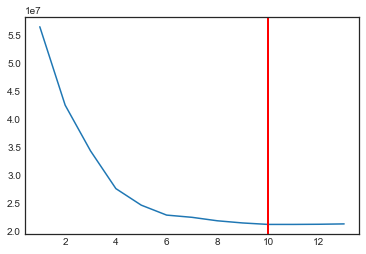

In [39]:
plt.figure()
sns.lineplot(x = range(1, len(X.columns)), y = -cv_errors) # transform the negative mse to positive
plt.axvline(x=np.argmax(cv_errors)+1, linewidth=2, color='r') # the argmax returns the index, so needs to add 1

--> Number of features is 10 has the lowest CV error.

---

### Question 4 - Regularized Regression [ 12 pts]

This question is very similar to what we did in Lab 2.

**4)a) Train a [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) on your dataset. Different to our Lab 2, use the `cross_val_score` (instead of the test and train MSE), and plot two graphs: coefficients vs alphas, and CV_error vs alphas. In the second graph find the lowest CV_error and draw a vertical line on the graph to indicate the alpha that corresponds to this value. What is your best alpha?**[3 pts]

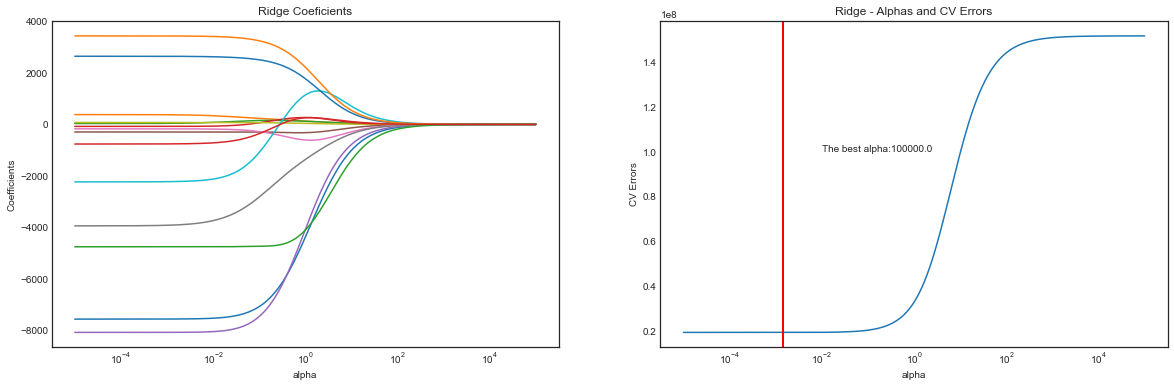

0.0014481182276745346


In [40]:
model_ridge = Ridge(normalize = True)
coeficents = []
cv_errors = []
alphas = np.logspace(-5, 5, 200)

for a in alphas:
    model_ridge.set_params(alpha=a)
    model_ridge.fit(X, y)
    coeficents.append(model_ridge.coef_)
    
    # calculate the mean cv_error; choose cv = 30 for convergence
    sum = mean(cross_val_score(Ridge(normalize = True, alpha = a), X, y, scoring='neg_mean_squared_error', cv = 30))
    cv_errors.append(sum)

cv_errors = list(map(lambda x:-x, cv_errors)) # make the negative mse positive
plt.figure(figsize=(20, 6))


plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coeficents)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coeficients')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, cv_errors,linestyle="-", label="Train")
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Errors')
plt.title('Ridge - Alphas and CV Errors')
plt.axis('tight')
plt.axvline(alphas[np.argmin(cv_errors)], linewidth=2, color='r')
plt.text(0.01, 100000000, 'The best alpha:'+ str(alphas[np.argmax(cv_errors)]))
plt.show()

print(alphas[np.argmin(cv_errors)])


 --> The best alpha is 0.001.

**4)b) Repeat your Ridge regression, but using RidgeCV, and print out the best alpha for this model. Is this alpha the same or close enough to the alpha calculated in 4)a)?**[3 pts]

In [14]:
alphas = np.logspace(-5, 5, 200)
model_ridge = RidgeCV(alphas = alphas,normalize = True, scoring='neg_mean_squared_error', cv = 30)
model_ridge.fit(X, y)
print(model_ridge.alpha_)
Best_Ridge_MSE = -model_ridge.best_score_
print(Best_Ridge_MSE )

0.0014481182276745346
19527705.955126103


--> The alpha is the same.

**4)a) Train a [Lasso regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) on your dataset. Different to our Lab 2, use the `cross_val_score` (instead of the test and train MSE), and plot two graphs: coefficients vs alphas, and CV_error vs alphas. In the second graph find the lowest CV_error and draw a vertical line on the graph to indicate the alpha that corresponds to this value. What is your best alpha?**[2 pts]

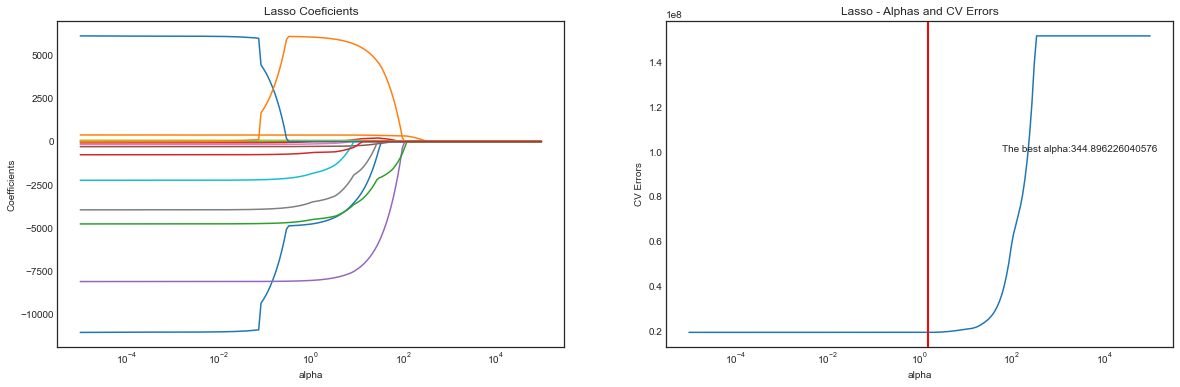

1.499268432786047


In [15]:
model_lasso = Lasso(normalize = True)
coeficents = []
cv_errors = []
alphas = np.logspace(-5, 5, 200)

for a in alphas:
    model_lasso.set_params(alpha=a)
    model_lasso.fit(X, y)
    coeficents.append(model_lasso.coef_)
    
    
    # calculate the mean cv_error, choose cv = 30
    sum = mean(cross_val_score(model_lasso, X, y, scoring='neg_mean_squared_error', cv = 30))
    cv_errors.append(sum)

cv_errors = list(map(lambda x:-x, cv_errors)) # make the negative mse positive
plt.figure(figsize=(20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coeficents)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coeficients')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, cv_errors,linestyle="-", label="Train")
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Errors')
plt.title('Lasso - Alphas and CV Errors')
plt.axis('tight')
plt.axvline(alphas[np.argmin(cv_errors)], linewidth=2, color='r')
plt.text(60, 100000000, 'The best alpha:'+ str(alphas[np.argmax(cv_errors)]))
plt.show()

print(alphas[np.argmin(cv_errors)])

--> The best alpha is 1.5.

**4)d) Repeat your Lasso regression, but using LassoCV, and print out the best alpha for this model. Is this alpha the same or close enough to the alpha calculated in 4)c)?**[2 pts]

In [16]:
coeficents = []
cv_errors = []
alphas = np.logspace(-5, 5, 200)
model_lasso = LassoCV(alphas = alphas, normalize = True, cv = 30)
model_lasso.fit(X, y)
print(model_lasso.alpha_)

Best_Lasso_MSE = np.min(np.mean(model_lasso.mse_path_))

1.499268432786047


--> They are the same.

**4)e) Print out the best results from your Lasso, Ridge and Linear regression. Which model works best with your data?** [2 pts]

*Note: If you didn't save your results from all your models, go back and modify your code from the previous questions.*

In [17]:
print('The best MSE for Lasso, Ridge, and Linear regression are {:.2f}, {:.2f}, and {:.2f}.'.format(Best_Lasso_MSE, Best_Ridge_MSE,linear_MSE))

The best MSE for Lasso, Ridge, and Linear regression are 57270226.24, 19527705.96, and 21634653.48.


--> RidgeCV works best with the data.

---

### Question 5 - Classifications and Comparisons [ 10 pts]

For this question we will another data set from [Kaggle](https://www.kaggle.com/prathamtripathi/drug-classification), related to Drug classification. Go ahead, download and read this dataset.

**5)a) Begin by creating a training and testing datasest from our `df_drugs` dataset, with a 70-30 ratio, and random_state=1.** [1 pts]

In [3]:
df_drugs = pd.read_csv('drug200.csv')
print(df_drugs.head())
df_drugs_clean = pd.concat([df_drugs, 
                            pd.get_dummies(df_drugs['BP'], prefix = 'BP', drop_first=True), 
                            pd.get_dummies(df_drugs['Cholesterol'], prefix = 'Cholesterol',drop_first=True),
                            pd.get_dummies(df_drugs['Sex'], prefix = 'Sex',drop_first=True)], axis = 1)
df_drugs_clean.drop(['BP', 'Cholesterol', 'Sex'], axis = 1, inplace = True)
print(df_drugs_clean.head(30))
X = df_drugs_clean[df_drugs_clean.columns.difference(['Drug'])]
y = df_drugs_clean['Drug']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY
    Age  Na_to_K   Drug  BP_LOW  BP_NORMAL  Cholesterol_NORMAL  Sex_M
0    23   25.355  DrugY       0          0                   0      0
1    47   13.093  drugC       1          0                   0      1
2    47   10.114  drugC       1          0                   0      1
3    28    7.798  drugX       0          1                   0      0
4    61   18.043  DrugY       1          0                   0      0
5    22    8.607  drugX       0          1                   0      0
6    49   16.275  DrugY       0          1                   0      0
7    41   11.037  drugC       1          0                   0      1
8    60   15.171  DrugY       0          1                   0      1
9    43   19.368  

**5)b) Train a KNN model for question 5)a), and print out its confusion matrix. How well did your model perform? Did it classify all classes the same? What was the accuracy? Include comments to explain your code.** [2 pts]

Accuracy:  0.6333333333333333


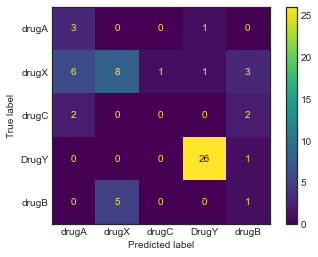

In [4]:
kmodel = KNeighborsClassifier()
kmodel.fit(X_train, y_train)
y_pred = kmodel.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred)) # 
conf_matrix = confusion_matrix(y_test, y_pred, labels=["drugA", "drugX", "drugC","DrugY", "drugB"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["drugA", "drugX", "drugC","DrugY", "drugB"])
disp.plot()
plt.show() 

--> An accuracy of 2/3 is just mediocre. The model works well for Y, but performs poorly on predicting X and C.

**5)c) Use cross validation to determine what is the optimal number of neighbors for your KNN model. Plot a graph of # neighbors vs accuracy of your model. Include comments to explain your code.** [2 pts]

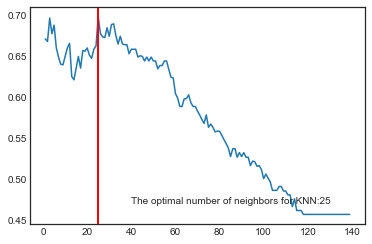

In [9]:
k_values = range(1,X_train.shape[0])
accuracy_values = []
for k in k_values:
    kmodel = KNeighborsClassifier(n_neighbors = k)
    accuracy_values.append(mean(cross_val_score(kmodel, X, y, scoring='accuracy', cv = 30))) # Gets the accuracy for every iteration of k

plt.figure()
plt.plot(k_values, accuracy_values)
plt.axvline(k_values[np.argmax(accuracy_values)], linewidth=2, color='r')
plt.text(40, 0.47, 'The optimal number of neighbors for KNN:'+ str(k_values[np.argmax(accuracy_values)]))
plt.show()

**5)d) Now that you have the optimal number of neighbors, re-train your model with this information. What is the new accuracy of your model? Print out the confusion matrix of this model and another metric that will help you justify how good this model is. Include comments to explain your code.** [2 pts]

Accuracy:  0.7


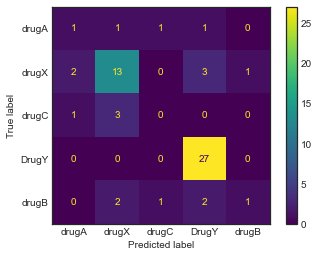

In [10]:
kmodel = KNeighborsClassifier(n_neighbors = 25) # Set number of neighbors to 24
kmodel.fit(X_train, y_train) # Fit the model
y_pred = kmodel.predict(X_test) 
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred)) # The accuracy is better
conf_matrix = confusion_matrix(y_test, y_pred, labels=["drugA", "drugX", "drugC","DrugY", "drugB"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["drugA", "drugX", "drugC","DrugY", "drugB"])
disp.plot()
plt.show() # False predition of X has dropped drastically.

--> The new accuracy is 0.7. False predition rate of X has dropped.

**5)e) Train a [Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) for your dataset, and print out its confusion matrix. How well did your model perform? Did it classify all classes the same? What was the accuracy? Include comments to explain your code.** [2 pts]

Accuracy:  0.8333333333333334


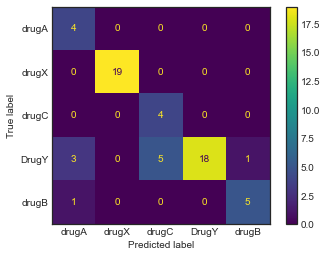

In [22]:
from sklearn.naive_bayes import GaussianNB
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)
y_pred = model_NB.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred)) 
conf_matrix = confusion_matrix(y_test, y_pred, labels=["drugA", "drugX", "drugC","DrugY", "drugB"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["drugA", "drugX", "drugC","DrugY", "drugB"])
disp.plot()
plt.show() 

--> # An accuracy of 0.83 is pretty good. The model works well for A, B X and C. However, this time it makes mistakes on predicting Y. 

**5)f) What classification model performed better? Why do you think this happened? Was there a particular class that was more difficult to classify? Justify your answers.** [ 1 pts]

--> Naive Bayes Classifier performed better. This is because NB has continuous predicted probability foe each observation. They can only perform well on either drug y or drug x. I guess there is something confusing between drug y and x. 

---

### REFERENCES

**List any references you used to complete your homework. Even if they are one of the books assigned for this class. If this section is incomplete you will be deducted 50% of your final grade from this homework.**
https://www.geeksforgeeks.org/plot-a-vertical-line-in-matplotlib/
https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

**Note: if there are no comments to explain your code you will receive 0 in this homework**

### Total Score:  --/50

### END OF HOMEWORK 2